**SETUP AND DATA LOADING**

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve,
                             precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

print(f"\n📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Period: {df['date'].min()} to {df['date'].max()}")
print(f"🎯 Target variable: drought_label (0=No Drought, 1=Moderate, 2=Severe)")


📊 Dataset loaded: 118 rows × 19 columns
📅 Period: 2015-01 to 2024-10
🎯 Target variable: drought_label (0=No Drought, 1=Moderate, 2=Severe)


**DATA PREPARATION**

In [4]:
print("\n" + "=" * 70)
print("DATA PREPARATION")
print("=" * 70)

# Select features for modeling
feature_cols = [
    'ndvi', 'precipitation_mm', 'temp_mean_c', 
    'precip_3month', 'precip_6month', 
    'ndvi_3month_avg', 'precip_3month_avg',
    'vci', 'precip_anomaly',
    'precip_lag1', 'ndvi_lag1'
]

# Remove rows with missing lag values
df_clean = df.dropna(subset=['precip_lag1', 'ndvi_lag1']).reset_index(drop=True)

X = df_clean[feature_cols]
y = df_clean['drought_label']

print(f"\n✓ Features selected: {len(feature_cols)} variables")
print(f"✓ Samples after removing NaN: {len(df_clean)} (removed {len(df) - len(df_clean)})")

print("\n📋 Feature List:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Check class distribution
print("\n📊 Class Distribution:")
print("-" * 70)
class_counts = y.value_counts().sort_index()
for label, count in class_counts.items():
    class_name = ['No Drought', 'Moderate Drought', 'Severe Drought'][label]
    pct = (count / len(y)) * 100
    print(f"  {label} ({class_name:18s}): {count:3d} samples ({pct:5.1f}%)")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train-Test Split (80-20):")
print(f"  • Training set: {len(X_train)} samples")
print(f"  • Test set: {len(X_test)} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



DATA PREPARATION

✓ Features selected: 11 variables
✓ Samples after removing NaN: 117 (removed 1)

📋 Feature List:
   1. ndvi
   2. precipitation_mm
   3. temp_mean_c
   4. precip_3month
   5. precip_6month
   6. ndvi_3month_avg
   7. precip_3month_avg
   8. vci
   9. precip_anomaly
  10. precip_lag1
  11. ndvi_lag1

📊 Class Distribution:
----------------------------------------------------------------------
  0 (No Drought        ):  46 samples ( 39.3%)
  1 (Moderate Drought  ):  16 samples ( 13.7%)
  2 (Severe Drought    ):  55 samples ( 47.0%)

✓ Train-Test Split (80-20):
  • Training set: 93 samples
  • Test set: 24 samples


**MODEL 1: LOGISTIC REGRESSION**

In [5]:
print("\n" + "=" * 70)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 70)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

# Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')

print("\n✓ Model trained successfully!")
print(f"\n📊 Performance Metrics:")
print("-" * 70)
print(f"  • Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"  • Precision: {lr_precision:.4f}")
print(f"  • Recall:    {lr_recall:.4f}")
print(f"  • F1-Score:  {lr_f1:.4f}")

print(f"\n📋 Detailed Classification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred_lr, 
                          target_names=['No Drought', 'Moderate Drought', 'Severe Drought']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\n🔢 Confusion Matrix:")
print("-" * 70)
print(cm_lr)

print("\n" + "=" * 70)


MODEL 1: LOGISTIC REGRESSION

✓ Model trained successfully!

📊 Performance Metrics:
----------------------------------------------------------------------
  • Accuracy:  0.7917 (79.17%)
  • Precision: 0.7569
  • Recall:    0.7917
  • F1-Score:  0.7736

📋 Detailed Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

      No Drought       0.90      0.90      0.90        10
Moderate Drought       0.00      0.00      0.00         3
  Severe Drought       0.83      0.91      0.87        11

        accuracy                           0.79        24
       macro avg       0.58      0.60      0.59        24
    weighted avg       0.76      0.79      0.77        24


🔢 Confusion Matrix:
----------------------------------------------------------------------
[[ 9  1  0]
 [ 1  0  2]
 [ 0  1 10]]



**MODEL 2: RANDOM FOREST**

In [6]:
print("\n" + "=" * 70)
print("MODEL 2: RANDOM FOREST")
print("=" * 70)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)  # RF doesn't need scaling

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

print("\n✓ Model trained successfully!")
print(f"\n📊 Performance Metrics:")
print("-" * 70)
print(f"  • Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"  • Precision: {rf_precision:.4f}")
print(f"  • Recall:    {rf_recall:.4f}")
print(f"  • F1-Score:  {rf_f1:.4f}")

print(f"\n📋 Detailed Classification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred_rf,
                          target_names=['No Drought', 'Moderate Drought', 'Severe Drought']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\n🔢 Confusion Matrix:")
print("-" * 70)
print(cm_rf)

print("\n" + "=" * 70)


MODEL 2: RANDOM FOREST

✓ Model trained successfully!

📊 Performance Metrics:
----------------------------------------------------------------------
  • Accuracy:  0.8750 (87.50%)
  • Precision: 0.8670
  • Recall:    0.8750
  • F1-Score:  0.8649

📋 Detailed Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

      No Drought       1.00      0.90      0.95        10
Moderate Drought       0.50      0.33      0.40         3
  Severe Drought       0.85      1.00      0.92        11

        accuracy                           0.88        24
       macro avg       0.78      0.74      0.75        24
    weighted avg       0.87      0.88      0.86        24


🔢 Confusion Matrix:
----------------------------------------------------------------------
[[ 9  1  0]
 [ 0  1  2]
 [ 0  0 11]]



**MODEL 3: XGBOOST**

In [7]:
print("\n" + "=" * 70)
print("MODEL 3: XGBoost")
print("=" * 70)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                         random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Evaluation
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision, xgb_recall, xgb_f1, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='weighted')

print("\n✓ Model trained successfully!")
print(f"\n📊 Performance Metrics:")
print("-" * 70)
print(f"  • Accuracy:  {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"  • Precision: {xgb_precision:.4f}")
print(f"  • Recall:    {xgb_recall:.4f}")
print(f"  • F1-Score:  {xgb_f1:.4f}")

print(f"\n📋 Detailed Classification Report:")
print("-" * 70)
print(classification_report(y_test, y_pred_xgb,
                          target_names=['No Drought', 'Moderate Drought', 'Severe Drought']))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\n🔢 Confusion Matrix:")
print("-" * 70)
print(cm_xgb)

print("\n" + "=" * 70)


MODEL 3: XGBoost

✓ Model trained successfully!

📊 Performance Metrics:
----------------------------------------------------------------------
  • Accuracy:  0.8750 (87.50%)
  • Precision: 0.8576
  • Recall:    0.8750
  • F1-Score:  0.8634

📋 Detailed Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

      No Drought       0.90      0.90      0.90        10
Moderate Drought       0.50      0.33      0.40         3
  Severe Drought       0.92      1.00      0.96        11

        accuracy                           0.88        24
       macro avg       0.77      0.74      0.75        24
    weighted avg       0.86      0.88      0.86        24


🔢 Confusion Matrix:
----------------------------------------------------------------------
[[ 9  1  0]
 [ 1  1  1]
 [ 0  0 11]]



**MODEL COMPARISON**


MODEL COMPARISON

📊 Performance Comparison:
----------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.791667   0.756944 0.791667  0.773551
      Random Forest  0.875000   0.866987 0.875000  0.864876
            XGBoost  0.875000   0.857639 0.875000  0.863406

🏆 BEST MODEL: Random Forest
   Accuracy: 0.8750 (87.50%)


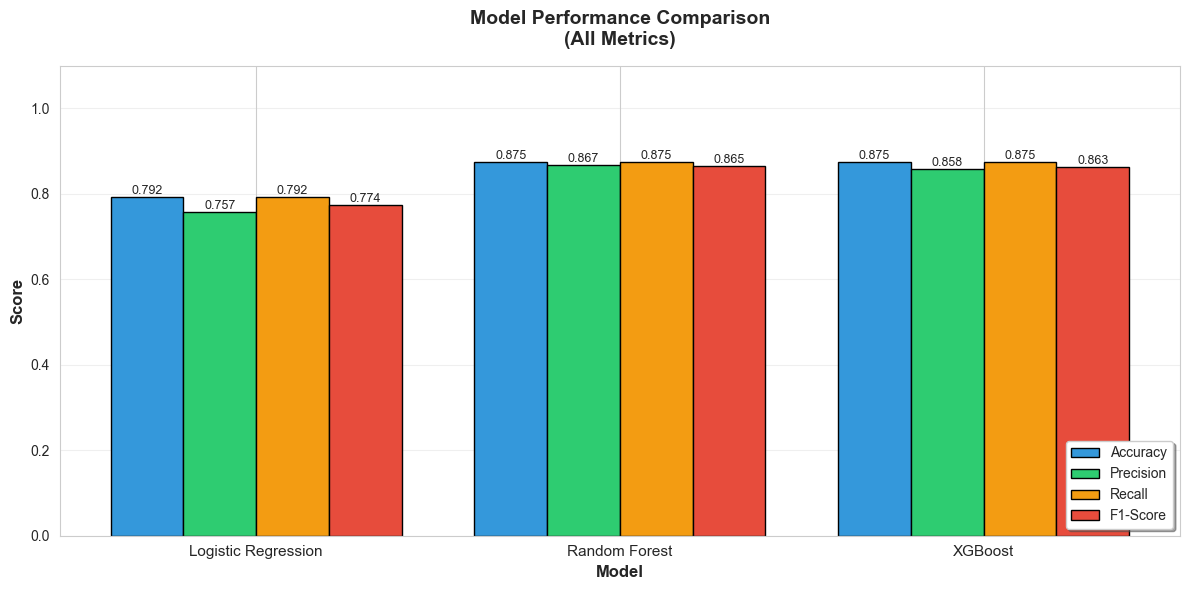


✓ Visualization saved: outputs/model_comparison.png


In [8]:
print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

# Comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1]
})

print("\n📊 Performance Comparison:")
print("-" * 70)
print(results.to_string(index=False))

# Find best model
best_model_idx = results['Accuracy'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']
best_accuracy = results.loc[best_model_idx, 'Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Visualization - Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, results[metric], width, label=metric, color=colors[i], 
                  edgecolor='black', linewidth=1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison\n(All Metrics)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(results['Model'], fontsize=11)
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('../outputs/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/model_comparison.png")
print("=" * 70)

**CONFUSION MATRIX VISUALIZATION**


CONFUSION MATRIX VISUALIZATION


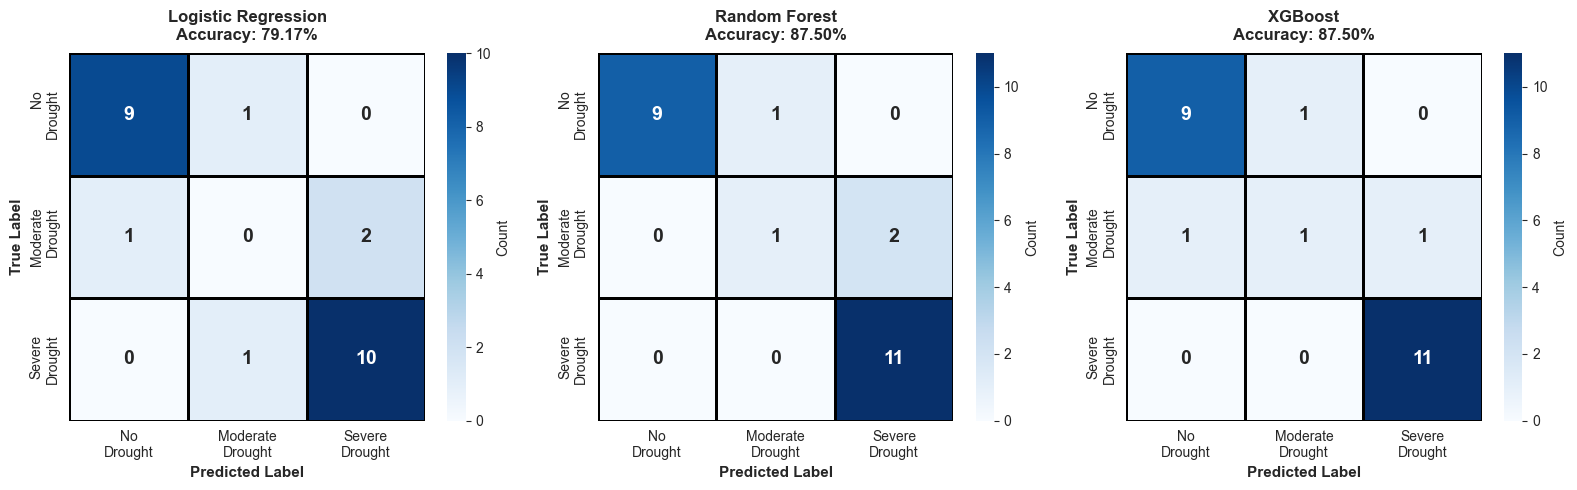


✓ Confusion matrices visualized
✓ Saved: outputs/confusion_matrices.png


In [9]:
print("\n" + "=" * 70)
print("CONFUSION MATRIX VISUALIZATION")
print("=" * 70)

# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

confusion_matrices = [
    (cm_lr, 'Logistic Regression', lr_accuracy),
    (cm_rf, 'Random Forest', rf_accuracy),
    (cm_xgb, 'XGBoost', xgb_accuracy)
]

class_names = ['No\nDrought', 'Moderate\nDrought', 'Severe\nDrought']

for idx, (cm, title, acc) in enumerate(confusion_matrices):
    ax = axes[idx]
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, linewidths=1, linecolor='black',
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})
    
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\nAccuracy: {acc:.2%}', fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('../outputs/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices visualized")
print("✓ Saved: outputs/confusion_matrices.png")
print("=" * 70)

**FEATURE IMPORTANCE ANALYSIS**


FEATURE IMPORTANCE ANALYSIS

🌟 Top 10 Most Important Features (Random Forest):
----------------------------------------------------------------------
          Feature  Importance
              vci    0.264134
             ndvi    0.180973
    precip_6month    0.133331
precip_3month_avg    0.097727
    precip_3month    0.094678
      precip_lag1    0.091759
  ndvi_3month_avg    0.046052
        ndvi_lag1    0.045544
 precipitation_mm    0.020684
   precip_anomaly    0.014065


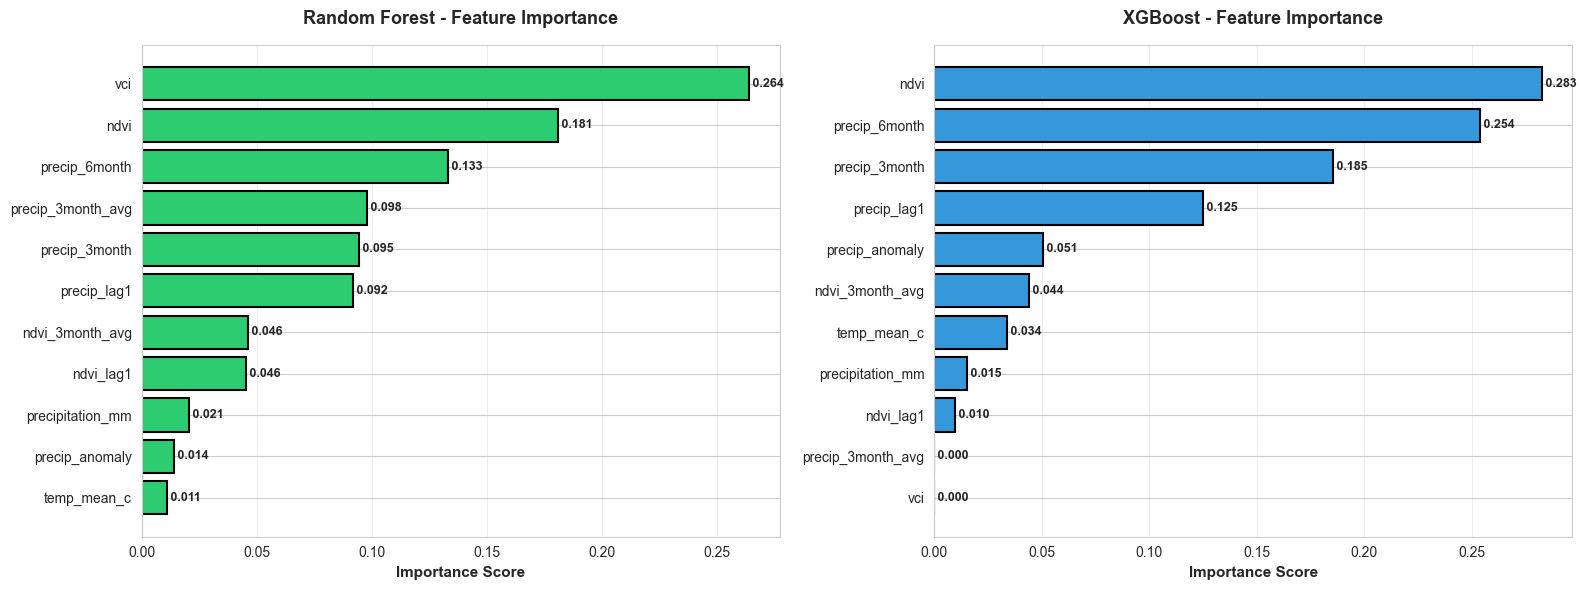


✓ Feature importance analysis complete
✓ Saved: outputs/feature_importance.png


In [10]:
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from Random Forest (best model)
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🌟 Top 10 Most Important Features (Random Forest):")
print("-" * 70)
print(feature_importance_rf.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
axes[0].barh(range(len(feature_importance_rf)), feature_importance_rf['Importance'],
            color='#2ecc71', edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(feature_importance_rf)))
axes[0].set_yticklabels(feature_importance_rf['Feature'], fontsize=10)
axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[0].set_title('Random Forest - Feature Importance', fontsize=13, fontweight='bold', pad=15)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(feature_importance_rf.iterrows()):
    axes[0].text(row['Importance'], i, f" {row['Importance']:.3f}",
                va='center', fontsize=9, fontweight='bold')

# XGBoost Feature Importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

axes[1].barh(range(len(feature_importance_xgb)), feature_importance_xgb['Importance'],
            color='#3498db', edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(feature_importance_xgb)))
axes[1].set_yticklabels(feature_importance_xgb['Feature'], fontsize=10)
axes[1].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[1].set_title('XGBoost - Feature Importance', fontsize=13, fontweight='bold', pad=15)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(feature_importance_xgb.iterrows()):
    axes[1].text(row['Importance'], i, f" {row['Importance']:.3f}",
                va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance analysis complete")
print("✓ Saved: outputs/feature_importance.png")
print("=" * 70)

In [12]:
# Save the best model
import joblib
joblib.dump(rf_model, '../models/random_forest_drought_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']